## ResNet50

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img


from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50

import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import math

from sklearn.metrics import accuracy_score

In [2]:
trainImagePath = '../dataSet/splitImages/train'
validationImagePath = '../dataSet/splitImages/val'
testImagePath = '../dataSet/splitImages/test'
checkpointPath = '../checkpoints/epoch_{epoch:04d}.ckpt'
logsPath = '../logs/fit/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
bestCheckpointPath = '../model/best/best_model'

batchSize = 64
imageWidth = 224
imageHeight = 224
imageChannel = 3


### 이미지 데이터 생성

ImageDataGenerator (train, validation)

In [3]:
trainDataGen = ImageDataGenerator(rescale=1./255,
                                  rotation_range = 30,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=20,
                                  zoom_range=0.3,
                                  horizontal_flip=False,
                                  vertical_flip=False,
                                  brightness_range=[0.7, 1.3],
                                  fill_mode='nearest',
                                  )

train set

In [4]:
trainGenSet = trainDataGen.flow_from_directory(
    trainImagePath,
    batch_size=batchSize,
    target_size=(imageWidth,imageHeight),
    class_mode='categorical',
    shuffle=True
)

Found 5601 images belonging to 44 classes.


validation set

In [5]:
validationGenSet = trainDataGen.flow_from_directory(
    validationImagePath,
    batch_size=batchSize,
    target_size=(imageWidth,imageHeight),
    class_mode='categorical',
)

Found 681 images belonging to 44 classes.


ImageDataGenerator (train, validation)

In [6]:
testDataGen = ImageDataGenerator(rescale=1./255)

test set

In [7]:
testGenSet = testDataGen.flow_from_directory(
    testImagePath,
    batch_size=batchSize,
    target_size=(imageWidth,imageHeight),
    class_mode='categorical'
)

Found 739 images belonging to 44 classes.


make model

In [8]:
model = tf.keras.Sequential([
  ResNet50(include_top=False, weights='imagenet', input_shape=(imageWidth, imageHeight, imageChannel)),
  GlobalAveragePooling2D(),
  Dropout(rate=0.0),
  Dense(1049, activation='relu' ),
  Dense(44, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1049)              2149401   
                                                                 
 dense_1 (Dense)             (None, 44)                46200     
                                                                 
Total params: 25,783,313
Trainable params: 25,730,193
Non-trainable params: 53,120
_______________________________________

model compile

In [9]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

difine callbacks

In [10]:
checkpoint = ModelCheckpoint(
                        checkpointPath, monitor='val_loss', verbose=0, save_best_only=False,
                        save_weights_only=False, mode='auto', save_freq='epoch'
                    )


In [11]:
earlyStopping = [
                    EarlyStopping(monitor='val_loss', patience=10, ),
                    ModelCheckpoint( bestCheckpointPath, monitor='val_loss', save_best_only=True )
                ]

In [12]:
tensorboard = tf.keras.callbacks.TensorBoard(logsPath, histogram_freq=1)

model fit

In [13]:
epochs = 200
history = model.fit(
    trainGenSet,
    epochs=epochs,
    validation_data=validationGenSet,
    callbacks=[checkpoint,earlyStopping, tensorboard],
    verbose=1
)

Epoch 1/200
88/88 [==============================] - ETA: 0s - loss: 0.5324 - accuracy: 0.8768 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0001.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0001.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


88/88 [==============================] - 1226s 14s/step - loss: 0.5324 - accuracy: 0.8768 - val_loss: 727.0529 - val_accuracy: 0.0220
Epoch 2/200
88/88 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9513 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0002.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0002.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


88/88 [==============================] - 1229s 14s/step - loss: 0.1717 - accuracy: 0.9513 - val_loss: 4.4260 - val_accuracy: 0.0220
Epoch 3/200
88/88 [==============================] - ETA: 0s - loss: 0.1112 - accuracy: 0.9713 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0003.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0003.ckpt/assets


88/88 [==============================] - 1126s 13s/step - loss: 0.1112 - accuracy: 0.9713 - val_loss: 18.7694 - val_accuracy: 0.0220
Epoch 4/200
88/88 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9900 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0004.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0004.ckpt/assets


88/88 [==============================] - 1186s 13s/step - loss: 0.0386 - accuracy: 0.9900 - val_loss: 4.7981 - val_accuracy: 0.0220
Epoch 5/200
88/88 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9963 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0005.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0005.ckpt/assets


88/88 [==============================] - 1182s 13s/step - loss: 0.0135 - accuracy: 0.9963 - val_loss: 9.3498 - val_accuracy: 0.0220
Epoch 6/200
88/88 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.9880 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0006.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0006.ckpt/assets


88/88 [==============================] - 1151s 13s/step - loss: 0.0467 - accuracy: 0.9880 - val_loss: 11.6061 - val_accuracy: 0.0235
Epoch 7/200
88/88 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9802 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0007.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0007.ckpt/assets


88/88 [==============================] - 1170s 13s/step - loss: 0.0721 - accuracy: 0.9802 - val_loss: 5.9007 - val_accuracy: 0.0367
Epoch 8/200
88/88 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9813 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0008.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0008.ckpt/assets


88/88 [==============================] - 1132s 13s/step - loss: 0.0757 - accuracy: 0.9813 - val_loss: 8.5556 - val_accuracy: 0.0235
Epoch 9/200
88/88 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9905 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0009.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0009.ckpt/assets


88/88 [==============================] - 1170s 13s/step - loss: 0.0337 - accuracy: 0.9905 - val_loss: 6.1883 - val_accuracy: 0.1454
Epoch 10/200
88/88 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 0.9909 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0010.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0010.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


88/88 [==============================] - 1208s 14s/step - loss: 0.0396 - accuracy: 0.9909 - val_loss: 3.4709 - val_accuracy: 0.2981
Epoch 11/200
88/88 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9945 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0011.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0011.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


88/88 [==============================] - 1164s 13s/step - loss: 0.0207 - accuracy: 0.9945 - val_loss: 2.2652 - val_accuracy: 0.5786
Epoch 12/200
88/88 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.9907 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0012.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0012.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


88/88 [==============================] - 1210s 14s/step - loss: 0.0308 - accuracy: 0.9907 - val_loss: 1.0192 - val_accuracy: 0.7210
Epoch 13/200
88/88 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9966 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0013.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0013.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


88/88 [==============================] - 1179s 13s/step - loss: 0.0097 - accuracy: 0.9966 - val_loss: 0.6883 - val_accuracy: 0.8076
Epoch 14/200
88/88 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9971 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0014.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0014.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


88/88 [==============================] - 1185s 13s/step - loss: 0.0087 - accuracy: 0.9971 - val_loss: 0.1615 - val_accuracy: 0.9471
Epoch 15/200
88/88 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9970 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0015.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0015.ckpt/assets


88/88 [==============================] - 1156s 13s/step - loss: 0.0141 - accuracy: 0.9970 - val_loss: 0.7274 - val_accuracy: 0.8370
Epoch 16/200
88/88 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9977 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0016.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0016.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


88/88 [==============================] - 1153s 13s/step - loss: 0.0087 - accuracy: 0.9977 - val_loss: 0.0765 - val_accuracy: 0.9765
Epoch 17/200
88/88 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9896 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0017.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0017.ckpt/assets


88/88 [==============================] - 1130s 13s/step - loss: 0.0389 - accuracy: 0.9896 - val_loss: 3.2064 - val_accuracy: 0.4728
Epoch 18/200
88/88 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9852 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0018.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0018.ckpt/assets


88/88 [==============================] - 1132s 13s/step - loss: 0.0563 - accuracy: 0.9852 - val_loss: 5.5228 - val_accuracy: 0.4332
Epoch 19/200
88/88 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.9834 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0019.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0019.ckpt/assets


88/88 [==============================] - 1157s 13s/step - loss: 0.0512 - accuracy: 0.9834 - val_loss: 5.8175 - val_accuracy: 0.4347
Epoch 20/200
88/88 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9916 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0020.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0020.ckpt/assets


88/88 [==============================] - 1151s 13s/step - loss: 0.0276 - accuracy: 0.9916 - val_loss: 0.4626 - val_accuracy: 0.9104
Epoch 21/200
88/88 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9945 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0021.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0021.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


88/88 [==============================] - 1166s 13s/step - loss: 0.0173 - accuracy: 0.9945 - val_loss: 0.0346 - val_accuracy: 0.9868
Epoch 22/200
88/88 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9920 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0022.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0022.ckpt/assets


88/88 [==============================] - 1132s 13s/step - loss: 0.0282 - accuracy: 0.9920 - val_loss: 0.7319 - val_accuracy: 0.8693
Epoch 23/200
88/88 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9979 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0023.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0023.ckpt/assets


88/88 [==============================] - 1179s 13s/step - loss: 0.0106 - accuracy: 0.9979 - val_loss: 0.3387 - val_accuracy: 0.9236
Epoch 24/200
88/88 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9968 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0024.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0024.ckpt/assets


88/88 [==============================] - 1138s 13s/step - loss: 0.0128 - accuracy: 0.9968 - val_loss: 0.6659 - val_accuracy: 0.8297
Epoch 25/200
88/88 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9986 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0025.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0025.ckpt/assets


88/88 [==============================] - 1173s 13s/step - loss: 0.0062 - accuracy: 0.9986 - val_loss: 0.0838 - val_accuracy: 0.9706
Epoch 26/200
88/88 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9950 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0026.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0026.ckpt/assets


88/88 [==============================] - 1171s 13s/step - loss: 0.0159 - accuracy: 0.9950 - val_loss: 0.5991 - val_accuracy: 0.8473
Epoch 27/200
88/88 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9973 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0027.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0027.ckpt/assets


88/88 [==============================] - 1159s 13s/step - loss: 0.0101 - accuracy: 0.9973 - val_loss: 1.4330 - val_accuracy: 0.7518
Epoch 28/200
88/88 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9918 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0028.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0028.ckpt/assets


88/88 [==============================] - 1157s 13s/step - loss: 0.0314 - accuracy: 0.9918 - val_loss: 2.0987 - val_accuracy: 0.6623
Epoch 29/200
88/88 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9902 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0029.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0029.ckpt/assets


88/88 [==============================] - 1143s 13s/step - loss: 0.0377 - accuracy: 0.9902 - val_loss: 0.5415 - val_accuracy: 0.8473
Epoch 30/200
88/88 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9932 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0030.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0030.ckpt/assets


88/88 [==============================] - 1360s 15s/step - loss: 0.0270 - accuracy: 0.9932 - val_loss: 0.3404 - val_accuracy: 0.9031
Epoch 31/200
88/88 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9989 

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0031.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0031.ckpt/assets



88/88 [==============================] - 1152s 13s/step - loss: 0.0033 - accuracy: 0.9989 - val_loss: 0.0711 - val_accuracy: 0.9736


In [14]:
scores = model.evaluate(testGenSet)
print(scores)

12/12 [==============================] - 124s 10s/step - loss: 0.4983 - accuracy: 0.8742
[0.49831336736679077, 0.874154269695282]


In [19]:
testLoss, testAccuracy = model.evaluate(testGenSet, verbose=0)

print("test_loss:", testLoss, "test_accuracy:", testAccuracy)

test_loss: 0.498313307762146 test_accuracy: 0.874154269695282


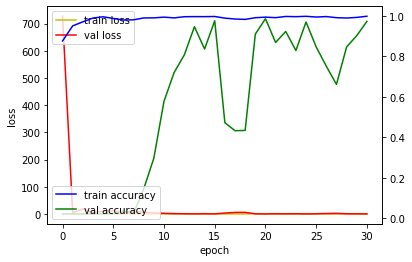

In [17]:


fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r', label = 'val loss')
acc_ax.plot(history.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

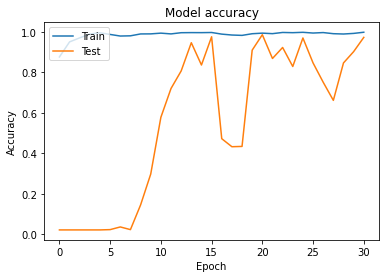

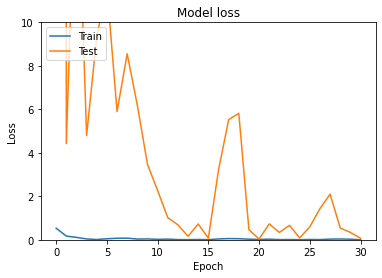

In [22]:
# 6 훈련 과정 시각화 (정확도)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 10])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
model.save('../model/resnetModel')

INFO:tensorflow:Assets written to: ../model/resnetModel/assets


INFO:tensorflow:Assets written to: ../model/resnetModel/assets


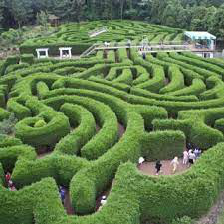

In [36]:
testImage = load_img("../testImage.jpg", target_size = (imageHeight, imageWidth))
testImage

In [37]:
testImage = img_to_array(testImage)
testImage = testImage/255.0

print(testImage)

[[[0.2627451  0.32941177 0.30588236]
  [0.22745098 0.2901961  0.2784314 ]
  [0.28627452 0.34901962 0.3372549 ]
  ...
  [0.34117648 0.40784314 0.43529412]
  [0.36862746 0.43529412 0.4627451 ]
  [0.36862746 0.44705883 0.4392157 ]]

 [[0.29411766 0.36078432 0.3372549 ]
  [0.20392157 0.26666668 0.25490198]
  [0.29803923 0.36078432 0.34901962]
  ...
  [0.28235295 0.3529412  0.36862746]
  [0.32156864 0.39215687 0.40784314]
  [0.29803923 0.38039216 0.36078432]]

 [[0.4        0.46666667 0.44313726]
  [0.36862746 0.43137255 0.41960785]
  [0.43529412 0.49803922 0.4862745 ]
  ...
  [0.30588236 0.3764706  0.3764706 ]
  [0.28627452 0.35686275 0.35686275]
  [0.34901962 0.43137255 0.40392157]]

 ...

 [[0.18039216 0.2784314  0.16078432]
  [0.18039216 0.2784314  0.16078432]
  [0.17254902 0.27058825 0.15294118]
  ...
  [0.5137255  0.56078434 0.40392157]
  [0.4862745  0.5372549  0.36862746]
  [0.49411765 0.5372549  0.40392157]]

 [[0.14509805 0.24313726 0.1254902 ]
  [0.14509805 0.24313726 0.1254902 ]


In [38]:
confidence = model.predict(testImage.reshape((1, imageHeight, imageWidth, imageChannel)))

1/1 [==============================] - 2s 2s/step


In [40]:
for i in range(confidence.shape[1]):
    print(f"{i} 일 확률 = {round(confidence[0][i], 3)}")

print(f"정답은 : {np.argmax(confidence, axis=1)}")

0 일 확률 = 0.0
1 일 확률 = 0.0
2 일 확률 = 0.0
3 일 확률 = 0.12600000202655792
4 일 확률 = 0.0
5 일 확률 = 0.0
6 일 확률 = 0.0
7 일 확률 = 0.0
8 일 확률 = 0.0
9 일 확률 = 0.0
10 일 확률 = 0.0
11 일 확률 = 0.0
12 일 확률 = 0.0
13 일 확률 = 0.0
14 일 확률 = 0.0
15 일 확률 = 0.0
16 일 확률 = 0.0
17 일 확률 = 0.0
18 일 확률 = 0.0
19 일 확률 = 0.0
20 일 확률 = 0.0
21 일 확률 = 0.0
22 일 확률 = 0.0
23 일 확률 = 0.0
24 일 확률 = 0.0
25 일 확률 = 0.0
26 일 확률 = 0.0
27 일 확률 = 0.0
28 일 확률 = 0.0
29 일 확률 = 0.0
30 일 확률 = 0.0
31 일 확률 = 0.0
32 일 확률 = 0.0
33 일 확률 = 0.8730000257492065
34 일 확률 = 0.0
35 일 확률 = 0.0
36 일 확률 = 0.0
37 일 확률 = 0.0
38 일 확률 = 0.0
39 일 확률 = 0.0
40 일 확률 = 0.0
41 일 확률 = 0.0
42 일 확률 = 0.0
43 일 확률 = 0.0
정답은 : [33]


In [42]:
dfTrain = pd.read_csv('../labelsCsv/trainLabels.csv')
dfTrain.head()

,Unnamed: 0,bBoxW,bBoxH,bBoxX,width,height,categoryId,bBoxY,fileName,categoryName
0,0,4000.0,2252.0,0.0,4000,2252,20813,0.0,검멀레동굴 _066_42469394.jpg,검멀레동굴
1,1,4000.0,2252.0,0.0,4000,2252,20813,0.0,검멀레동굴 _067_42469395.jpg,검멀레동굴
2,2,4000.0,2252.0,0.0,4000,2252,20813,0.0,검멀레동굴 _068_42469396.jpg,검멀레동굴
3,3,4000.0,2252.0,0.0,4000,2252,20813,0.0,검멀레동굴 _104_42469397.jpg,검멀레동굴
4,4,4000.0,2252.0,0.0,4000,2252,20813,0.0,검멀레동굴 _106_42469399.jpg,검멀레동굴


In [46]:
dfTrain['categoryName'].unique()[np.argmax(confidence, axis=1)][0]

'제주절물자연휴양림'

In [49]:
dfTrain['categoryName'].unique()[3]

'김녕미로공원'